In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 11.8 MB/s eta 0:00:00


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split

# TRX-USD

In [ ]:
# Đọc dữ liệu từ file CSV
df = pd.read_csv('/content/drive/MyDrive/HK6_2022-2023/IS403.N22.HTCL - Phân tích dữ liệu kinh doanh/IS403_Team15/Project/Dataset/TRX-USD.csv')

# Xử lý dữ liệu
df = df[['Date', 'Close', 'Volume']]  # Chỉ lấy cột 'Date', 'Close' và 'Volume'
df['Date'] = pd.to_datetime(df['Date'])
df = df.dropna().reset_index(drop=True)

## Tỉ lệ 7:2:1

In [ ]:
# Chia train, test, validate theo tỉ lệ 7:2:1
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [ ]:
# Tiến hành huấn luyện mô hình ARIMAX
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])
exog_train = np.array(train_data['Volume']).reshape(-1, 1)  # Sử dụng cột 'Volume' làm biến exogenous


In [ ]:
# Tìm mô hình ARIMAX tốt nhất bằng cách sử dụng auto_arima
model = auto_arima(y_train, exogenous=exog_train, trace=True, error_action='ignore', suppress_warnings=True)
# Fit mô hình
model.fit(y_train, exogenous=exog_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-10799.776, Time=3.43 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-10804.672, Time=0.31 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-10803.055, Time=0.47 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-10802.932, Time=1.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-10806.438, Time=0.20 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-10801.031, Time=2.20 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 7.773 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [ ]:
# Kiểm tra trên tập test
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
exog_test = np.array(test_data['Volume']).reshape(-1, 1)  # Sử dụng cột 'Volume' làm biến exogenous
y_pred = model.predict(n_periods=len(y_test), exogenous=exog_test)

# Kiểm tra trên tập validate
x_val = np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
exog_val = np.array(val_data['Volume']).reshape(-1, 1)  # Sử dụng cột 'Volume' làm biến exogenous
y_pred_val = model.predict(n_periods=len(y_val), exogenous=exog_val)

In [ ]:
# Dự đoán giá 7 ngày tiếp theo
num_days = 7
last_date = df['Date'].iloc[-1]  # Ngày cuối cùng trong tập dữ liệu
next_dates = pd.date_range(start=last_date + pd.DateOffset(1), periods=num_days, freq='D')  # Tạo danh sách các ngày tiếp theo
exog_next = np.array(val_data['Volume']).reshape(-1, 1)  # Sử dụng cột 'Volume' làm biến exogenous
next_prices = model.predict(n_periods=num_days, exogenous=exog_next)
predicted_prices = [f"Day {i+1}: {price}" for i, price in enumerate(next_prices)]

# In ra kết quả dự đoán 7 ngày tiếp theo
print('Predicted Prices for the Next 7 Days:')
for prediction in predicted_prices:
    print(prediction)


Predicted Prices for the Next 7 Days:
Day 1: 0.0971620008349418
Day 2: 0.0971620008349418
Day 3: 0.0971620008349418
Day 4: 0.0971620008349418
Day 5: 0.0971620008349418
Day 6: 0.0971620008349418
Day 7: 0.0971620008349418


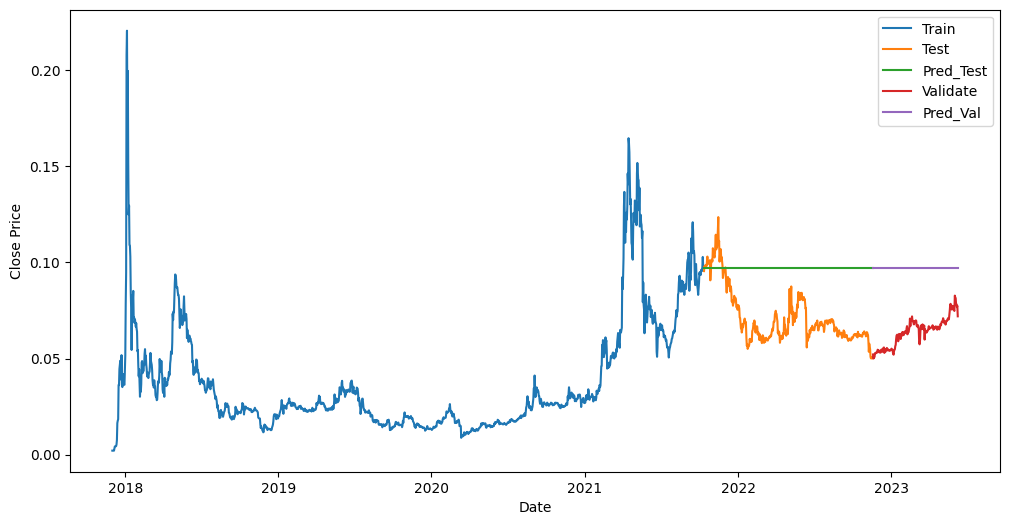

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train_data['Date'], train_data['Close'], label='Train')
plt.plot(test_data['Date'], test_data['Close'], label='Test')
plt.plot(test_data['Date'], y_pred, label='Pred_Test')
plt.plot(val_data['Date'], val_data['Close'], label='Validate')
plt.plot(val_data['Date'], y_pred_val, label='Pred_Val')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

In [ ]:
# Tính MAE
valid_mae = mean_absolute_error(y_val, y_pred_val)
test_mae = mean_absolute_error(y_test, y_pred)

# Tính toán RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))

# Tính MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

valid_mape = mean_absolute_percentage_error(y_val, y_pred_val)
test_mape = mean_absolute_percentage_error(y_test, y_pred)

# Làm tròn đến số thứ 3 sau dấu phẩy
valid_mae = round(valid_mae, 3)
test_mae = round(test_mae, 3)
valid_rmse = round(valid_rmse, 3)
test_rmse = round(test_rmse, 3)
valid_mape = round(valid_mape, 3)
test_mape = round(test_mape, 3)

print('Validation MAE:', valid_mae)
print('Validation RMSE:', valid_rmse)
print('Validation MAPE:', valid_mape)
print('Testing MAE:', test_mae)
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)

Validation MAE: 0.033
Validation RMSE: 0.034
Validation MAPE: 54.299
Testing MAE: 0.027
Testing RMSE: 0.029
Testing MAPE: 41.365


In [ ]:
test_data.index

RangeIndex(start=1411, stop=1814, step=1)

## Tỉ lệ 5:3:2

In [ ]:
# Chia train, test, validate theo tỉ lệ 5:3:2
train_size1 = int(0.5 * len(df))
test_size1 = int(0.3 * len(df))
val_size1 = len(df) - train_size1 - test_size1

train_data1 = df[:train_size1]
test_data1 = df[train_size1:train_size1+test_size1]
val_data1 = df[train_size1+test_size1:]

In [ ]:
# Tiến hành huấn luyện mô hình ARIMAX
x_train1 = np.array(train_data1.index).reshape(-1, 1)
y_train1 = np.array(train_data1['Close'])
exog_train1 = np.array(train_data1['Volume']).reshape(-1, 1)  # Sử dụng cột 'Volume' làm biến exogenous

# Tìm mô hình ARIMAX tốt nhất bằng cách sử dụng auto_arima
model = auto_arima(y_train1, exogenous=exog_train1, trace=True, error_action='ignore', suppress_warnings=True)

# Fit mô hình
model.fit(y_train1, exogenous=exog_train1)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-7804.328, Time=3.68 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-7749.881, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-7753.469, Time=1.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-7753.165, Time=0.62 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-7751.823, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-7808.144, Time=8.66 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-7747.564, Time=3.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-7745.880, Time=0.73 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-7872.431, Time=5.57 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-7850.662, Time=8.35 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-7880.762, Time=10.57 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-7880.316, Time=8.59 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=-7886.439, Time=2.49 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-7888.373, Time=4.52 sec
 ARIMA(0,1,4)(0,0,

ARIMA(order=(1, 1, 5), scoring_args={}, suppress_warnings=True)

In [ ]:
# Kiểm tra trên tập test
x_test1 = np.array(test_data1.index).reshape(-1, 1)
y_test1 = np.array(test_data1['Close'])
exog_test1 = np.array(test_data1['Volume']).reshape(-1, 1)  # Sử dụng cột 'Volume' làm biến exogenous
y_pred1 = model.predict(n_periods=len(y_test1), exogenous=exog_test1)

# Kiểm tra trên tập validate
x_val1 = np.array(val_data1.index).reshape(-1, 1)
y_val1 = np.array(val_data1['Close'])
exog_val1 = np.array(val_data1['Volume']).reshape(-1, 1)  # Sử dụng cột 'Volume' làm biến exogenous
y_pred_val1 = model.predict(n_periods=len(y_val1), exogenous=exog_val1)


In [ ]:
# Dự đoán giá 7 ngày tiếp theo
num_days = 7
last_date1 = df['Date'].iloc[-1]  # Ngày cuối cùng trong tập dữ liệu
next_dates1 = pd.date_range(start=last_date1 + pd.DateOffset(1), periods=num_days, freq='D')  # Tạo danh sách các ngày tiếp theo
exog_next1 = np.array(val_data1['Volume']).reshape(-1, 1)  # Sử dụng cột 'Volume' làm biến exogenous
next_prices1 = model.predict(n_periods1=num_days, exogenous=exog_next1)
predicted_prices1 = [f"Day {i+1}: {price}" for i, price in enumerate(next_prices1)]

# In ra kết quả dự đoán 7 ngày tiếp theo
print('Predicted Prices for the Next 7 Days:')
for prediction in predicted_prices1:
    print(prediction)

Predicted Prices for the Next 7 Days:
Day 1: 0.043276608002014966
Day 2: 0.041391141211731236
Day 3: 0.043072320824296524
Day 4: 0.04157865199298553
Day 5: 0.04089121657927685
Day 6: 0.04076674552659892
Day 7: 0.04076711686630154
Day 8: 0.04079517312535993
Day 9: 0.04082936876339944
Day 10: 0.04086492586374951


In [ ]:
# In ra kết quả dự đoán 7 ngày trước
print('Predicted Prices for the Previous 7 Days:')
previous_prices1 = y_pred1[-7:]  # Lấy 7 dự đoán gần nhất
for i, price in enumerate(previous_prices1):
    day = len(y_train1) + len(y_test1) + i + 1
    print(f"Day {day}: {price}")

Predicted Prices for the Previous 7 Days:
Day 1614: 0.062036448353803175
Day 1615: 0.06207239340140116
Day 1616: 0.06210833844899914
Day 1617: 0.062144283496597126
Day 1618: 0.06218022854419511
Day 1619: 0.06221617359179309
Day 1620: 0.06225211863939108


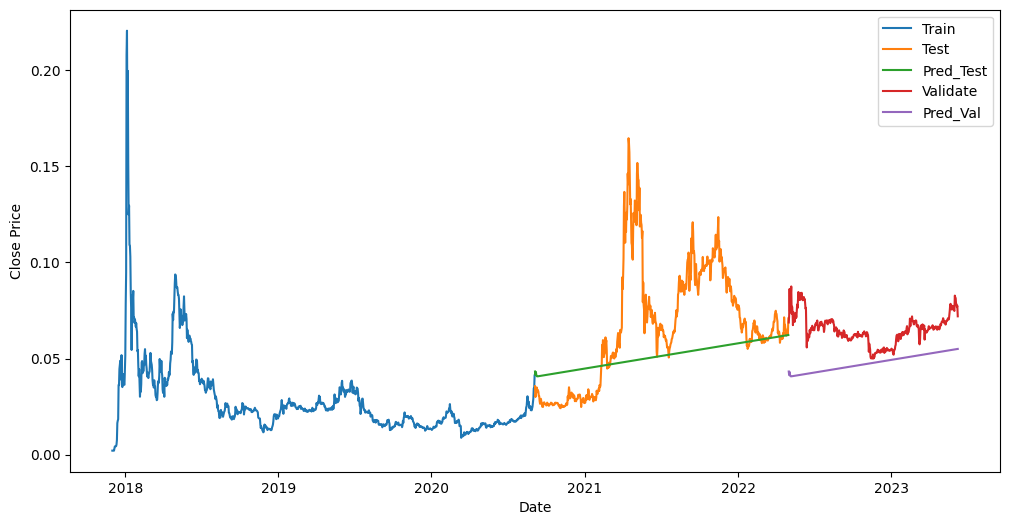

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train_data1['Date'], train_data1['Close'], label='Train')
plt.plot(test_data1['Date'], test_data1['Close'], label='Test')
plt.plot(test_data1['Date'], y_pred1, label='Pred_Test')
plt.plot(val_data1['Date'], val_data1['Close'], label='Validate')
plt.plot(val_data1['Date'], y_pred_val1, label='Pred_Val')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

In [ ]:
# Tính MAE
valid_mae1 = mean_absolute_error(y_val1, y_pred_val1)
test_mae1 = mean_absolute_error(y_test1, y_pred1)

# Tính toán RMSE
valid_rmse1 = np.sqrt(np.mean((y_pred_val1 - y_val1)**2))
test_rmse1 = np.sqrt(np.mean((y_pred1 - y_test1)**2))

# Tính MAPE
def mean_absolute_percentage_error(y_true, y_pred1):
    return np.mean(np.abs((y_true - y_pred1) / y_true)) * 100

valid_mape1 = mean_absolute_percentage_error(y_val1, y_pred_val1)
test_mape1 = mean_absolute_percentage_error(y_test1, y_pred1)

# Làm tròn đến số thứ 3 sau dấu phẩy
valid_mae1 = round(valid_mae1, 3)
test_mae1 = round(test_mae1, 3)
valid_rmse1 = round(valid_rmse1, 3)
test_rmse1 = round(test_rmse1, 3)
valid_mape1 = round(valid_mape1, 3)
test_mape1 = round(test_mape1, 3)

print('Validation MAE:', valid_mae1)
print('Validation RMSE:', valid_rmse1)
print('Validation MAPE:', valid_mape1)
print('Testing MAE:', test_mae1)
print('Testing RMSE:', test_rmse1)
print('Testing MAPE:', test_mape1)

Validation MAE: 0.017
Validation RMSE: 0.02
Validation MAPE: 25.642
Testing MAE: 0.023
Testing RMSE: 0.032
Testing MAPE: 33.778


In [ ]:
test_data.index

RangeIndex(start=1411, stop=1814, step=1)

## Tỉ lệ 6:2:2

In [ ]:
# Chia train, test, validate theo tỉ lệ 6:2:2
train_size = int(0.6 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [ ]:
# Tiến hành huấn luyện mô hình ARIMAX
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])
exog_train = np.array(train_data['Volume']).reshape(-1, 1)  # Sử dụng cột 'Volume' làm biến exogenous


In [ ]:
# Tìm mô hình ARIMAX tốt nhất bằng cách sử dụng auto_arima
model = auto_arima(y_train, exogenous=exog_train, trace=True, error_action='ignore', suppress_warnings=True)
# Fit mô hình
model.fit(y_train, exogenous=exog_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-9544.714, Time=5.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-9487.923, Time=0.53 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-9491.907, Time=0.39 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-9491.566, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-9489.817, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-9548.913, Time=3.30 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-9485.569, Time=0.74 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-9483.921, Time=0.49 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-9618.085, Time=1.14 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-9597.912, Time=2.29 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-9620.682, Time=1.97 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-9620.918, Time=2.62 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-9621.309, Time=3.63 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-9541.259, Time=0.79 sec
 ARIMA(4,1,2)(0,0,0

ARIMA(order=(4, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [ ]:
# Kiểm tra trên tập test
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
exog_test = np.array(test_data['Volume']).reshape(-1, 1)  # Sử dụng cột 'Volume' làm biến exogenous
y_pred = model.predict(n_periods=len(y_test), exogenous=exog_test)

# Kiểm tra trên tập validate
x_val = np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
exog_val = np.array(val_data['Volume']).reshape(-1, 1)  # Sử dụng cột 'Volume' làm biến exogenous
y_pred_val = model.predict(n_periods=len(y_val), exogenous=exog_val)

In [ ]:
# Dự đoán giá 7 ngày tiếp theo
num_days = 7
last_date = df['Date'].iloc[-1]  # Ngày cuối cùng trong tập dữ liệu
next_dates = pd.date_range(start=last_date + pd.DateOffset(1), periods=num_days, freq='D')  # Tạo danh sách các ngày tiếp theo
exog_next = np.array(val_data['Volume']).reshape(-1, 1)  # Sử dụng cột 'Volume' làm biến exogenous
next_prices = model.predict(n_periods=num_days, exogenous=exog_next)
predicted_prices = [f"Day {i+1}: {price}" for i, price in enumerate(next_prices)]

# In ra kết quả dự đoán 7 ngày tiếp theo
print('Predicted Prices for the Next 7 Days:')
for prediction in predicted_prices:
    print(prediction)
print('--------------------------------------')
# In ra kết quả dự đoán 7 ngày trước
print('Predicted Prices for the Previous 7 Days:')
previous_prices = y_pred[-7:]  # Lấy 7 dự đoán gần nhất
for i, price in enumerate(previous_prices):
    day = len(y_train) + len(y_test) + i + 1
    print(f"Day {day}: {price}")

Predicted Prices for the Next 7 Days:
Day 1: 0.05367710296405833
Day 2: 0.05406576840287583
Day 3: 0.05315723338340073
Day 4: 0.05348267159945541
Day 5: 0.05416033422771637
Day 6: 0.0541595924717122
Day 7: 0.05475566864316713
--------------------------------------
Predicted Prices for the Previous 7 Days:
Day 1614: 0.054913394911308
Day 1615: 0.054913394911308
Day 1616: 0.054913394911308
Day 1617: 0.054913394911308
Day 1618: 0.054913394911308
Day 1619: 0.054913394911308
Day 1620: 0.054913394911308


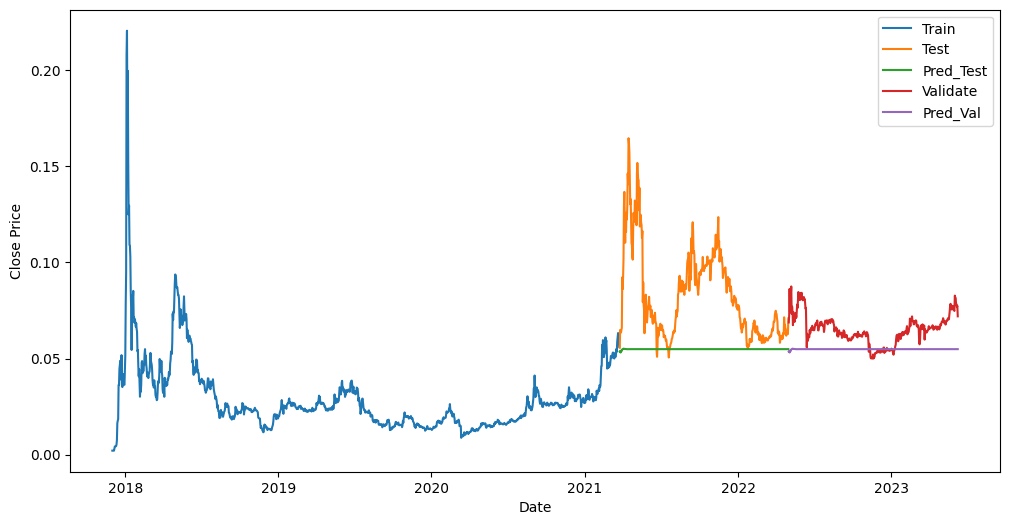

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train_data['Date'], train_data['Close'], label='Train')
plt.plot(test_data['Date'], test_data['Close'], label='Test')
plt.plot(test_data['Date'], y_pred, label='Pred_Test')
plt.plot(val_data['Date'], val_data['Close'], label='Validate')
plt.plot(val_data['Date'], y_pred_val, label='Pred_Val')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

In [ ]:
# Tính MAE
valid_mae = mean_absolute_error(y_val, y_pred_val)
test_mae = mean_absolute_error(y_test, y_pred)

# Tính toán RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))

# Tính MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

valid_mape = mean_absolute_percentage_error(y_val, y_pred_val)
test_mape = mean_absolute_percentage_error(y_test, y_pred)

# Làm tròn đến số thứ 3 sau dấu phẩy
valid_mae = round(valid_mae, 3)
test_mae = round(test_mae, 3)
valid_rmse = round(valid_rmse, 3)
test_rmse = round(test_rmse, 3)
valid_mape = round(valid_mape, 3)
test_mape = round(test_mape, 3)

print('Validation MAE:', valid_mae)
print('Validation RMSE:', valid_rmse)
print('Validation MAPE:', valid_mape)
print('Testing MAE:', test_mae)
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)

Validation MAE: 0.011
Validation RMSE: 0.013
Validation MAPE: 15.528
Testing MAE: 0.028
Testing RMSE: 0.037
Testing MAPE: 29.546


In [ ]:
test_data.index

RangeIndex(start=1210, stop=1613, step=1)

# DOGE-USD

In [6]:
# Đọc dữ liệu từ file CSV
df1 = pd.read_csv('/content/drive/MyDrive/HK6_2022-2023/IS403.N22.HTCL - Phân tích dữ liệu kinh doanh/IS403_Team15/Project/Dataset/DOGE-USD.csv')

# Xử lý dữ liệu
df1 = df1[['Date', 'Close', 'Volume']]  # Chỉ lấy cột 'Date', 'Close' và 'Volume'
df1['Date'] = pd.to_datetime(df1['Date'])
df1 = df1.dropna().reset_index(drop=True)

## Tỉ lệ 7:2:1

In [ ]:
# Chia train, test, validate theo tỉ lệ 7:2:1
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [ ]:
# Tiến hành huấn luyện mô hình ARIMAX
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])
exog_train = np.array(train_data['Volume']).reshape(-1, 1)  # Sử dụng cột 'Volume' làm biến exogenous


In [ ]:
# Tìm mô hình ARIMAX tốt nhất bằng cách sử dụng auto_arima
model = auto_arima(y_train, exogenous=exog_train, trace=True, error_action='ignore', suppress_warnings=True)
# Fit mô hình
model.fit(y_train, exogenous=exog_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-8187.891, Time=3.85 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-8161.669, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-8182.490, Time=0.27 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-8178.693, Time=0.82 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-8163.460, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-8211.213, Time=2.00 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-8199.423, Time=2.43 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-8183.319, Time=2.00 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-8235.037, Time=4.72 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-8237.062, Time=5.16 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-8235.027, Time=2.21 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-8239.603, Time=7.05 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=-8270.552, Time=4.27 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-8269.645, Time=3.34 sec
 ARIMA(3,1,4)(0,0,0

ARIMA(order=(5, 1, 4), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [ ]:
# Kiểm tra trên tập test
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
exog_test = np.array(test_data['Volume']).reshape(-1, 1)  # Sử dụng cột 'Volume' làm biến exogenous
y_pred = model.predict(n_periods=len(y_test), exogenous=exog_test)

# Kiểm tra trên tập validate
x_val = np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
exog_val = np.array(val_data['Volume']).reshape(-1, 1)  # Sử dụng cột 'Volume' làm biến exogenous
y_pred_val = model.predict(n_periods=len(y_val), exogenous=exog_val)

In [ ]:
# # Tạo index dự đoán cho 30 ngày tiếp theo
# last_index = df.index[-1]
# x_next_30_days = np.array(range(last_index + 1, last_index + 31)).reshape(-1, 1)
# y_next_30_days = model.predict(n_periods=len(x_next_30_days), exogenous=x_next_30_days)

# # In ra kết quả dự đoán 30 ngày
# print('Predicted closing prices for the next 30 days:')
# for i in range(len(y_next_30_days)):
#     print(f'Day {i+1}: {y_next_30_days[i]}')


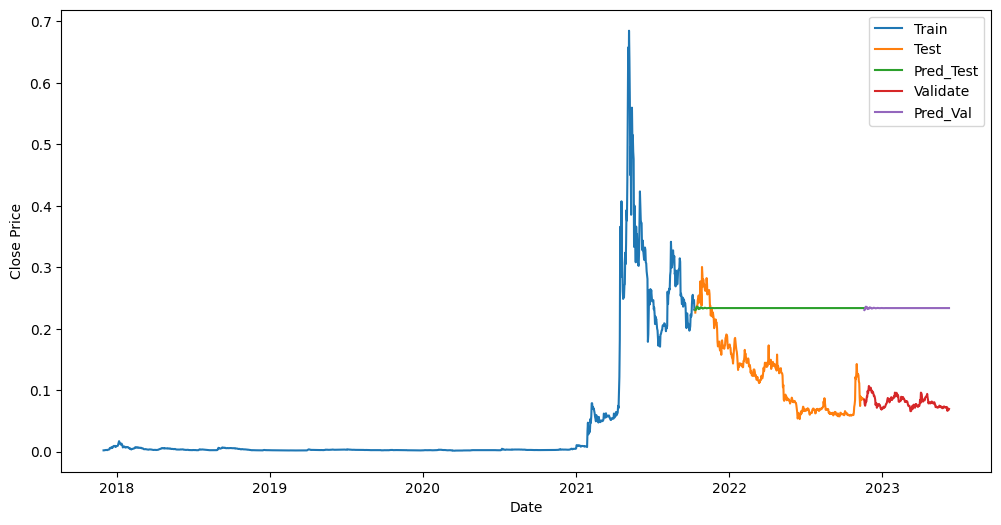

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train_data['Date'], train_data['Close'], label='Train')
plt.plot(test_data['Date'], test_data['Close'], label='Test')
plt.plot(test_data['Date'], y_pred, label='Pred_Test')
plt.plot(val_data['Date'], val_data['Close'], label='Validate')
plt.plot(val_data['Date'], y_pred_val, label='Pred_Val')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

In [ ]:
# Dự đoán giá 7 ngày tiếp theo
num_days = 7
last_date = df['Date'].iloc[-1]  # Ngày cuối cùng trong tập dữ liệu
next_dates = pd.date_range(start=last_date + pd.DateOffset(1), periods=num_days, freq='D')  # Tạo danh sách các ngày tiếp theo
exog_next = np.array(val_data['Volume']).reshape(-1, 1)  # Sử dụng cột 'Volume' làm biến exogenous
next_prices = model.predict(n_periods=num_days, exogenous=exog_next)
predicted_prices = [f"Day {i+1}: {price}" for i, price in enumerate(next_prices)]

# In ra kết quả dự đoán 7 ngày tiếp theo
print('Predicted Prices for the Next 7 Days:')
for prediction in predicted_prices:
    print(prediction)
print('--------------------------------------')
# In ra kết quả dự đoán 7 ngày trước
print('Predicted Prices for the Previous 7 Days:')
previous_prices = y_pred[-7:]  # Lấy 7 dự đoán gần nhất
for i, price in enumerate(previous_prices):
    day = len(y_train) + len(y_test) + i + 1
    print(f"Day {day}: {price}")

Predicted Prices for the Next 7 Days:
Day 1: 0.2304605750706236
Day 2: 0.23126390956481674
Day 3: 0.2312615984835353
Day 4: 0.2353710106368099
Day 5: 0.23593655579557662
Day 6: 0.2349822637692956
Day 7: 0.235385158386251
--------------------------------------
Predicted Prices for the Previous 7 Days:
Day 1815: 0.23358979534282967
Day 1816: 0.23358979534282967
Day 1817: 0.23358979534282967
Day 1818: 0.23358979534282967
Day 1819: 0.23358979534282967
Day 1820: 0.23358979534282967
Day 1821: 0.23358979534282967


In [ ]:
# Tính MAE
valid_mae = mean_absolute_error(y_val, y_pred_val)
test_mae = mean_absolute_error(y_test, y_pred)

# Tính toán RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))

# Tính MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

valid_mape = mean_absolute_percentage_error(y_val, y_pred_val)
test_mape = mean_absolute_percentage_error(y_test, y_pred)

# Làm tròn đến số thứ 3 sau dấu phẩy
valid_mae = round(valid_mae, 3)
test_mae = round(test_mae, 3)
valid_rmse = round(valid_rmse, 3)
test_rmse = round(test_rmse, 3)
valid_mape = round(valid_mape, 3)
test_mape = round(test_mape, 3)

print('Validation MAE:', valid_mae)
print('Validation RMSE:', valid_rmse)
print('Validation MAPE:', valid_mape)
print('Testing MAE:', test_mae)
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)

Validation MAE: 0.153
Validation RMSE: 0.153
Validation MAPE: 192.462
Testing MAE: 0.114
Testing RMSE: 0.126
Testing MAPE: 137.832


In [ ]:
test_data.index

RangeIndex(start=1411, stop=1814, step=1)

## Tỉ lệ 5:3:2

In [8]:
# Chia train, test, validate theo tỉ lệ 5:3:2
train_size1 = int(0.5 * len(df1))
test_size1 = int(0.3 * len(df1))
val_size1 = len(df1) - train_size1 - test_size1

train_data1 = df1[:train_size1]
test_data1 = df1[train_size1:train_size1+test_size1]
val_data1 = df1[train_size1+test_size1:]

In [9]:
# Tiến hành huấn luyện mô hình ARIMAX
x_train1 = np.array(train_data1.index).reshape(-1, 1)
y_train1 = np.array(train_data1['Close'])
exog_train1 = np.array(train_data1['Volume']).reshape(-1, 1)  # Sử dụng cột 'Volume' làm biến exogenous

# Tìm mô hình ARIMAX tốt nhất bằng cách sử dụng auto_arima
model = auto_arima(y_train1, exogenous=exog_train1, trace=True, error_action='ignore', suppress_warnings=True)

# Fit mô hình
model.fit(y_train1, exogenous=exog_train1)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-13331.584, Time=1.79 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-13325.688, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-13343.252, Time=0.24 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-13343.617, Time=1.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-13327.683, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-13341.589, Time=0.85 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-13340.981, Time=0.55 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-13344.336, Time=0.69 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-13339.416, Time=3.37 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-13340.236, Time=2.86 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-13319.537, Time=0.65 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-13336.925, Time=2.13 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-13346.107, Time=0.60 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-13342.983, Time=0.64 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-13343.583, Time=1.16 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-13333.709, Time=0.68 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=-13341.419, Time=2.66 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-13345.617, Time=0.72 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-13342.243, Time=2.18 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-13321.541, Time=1.05 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=-13338.935, Time=2.43 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0]          
Total fit time: 26.723 seconds


ARIMA(order=(1, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [10]:
# Kiểm tra trên tập test
x_test1 = np.array(test_data1.index).reshape(-1, 1)
y_test1 = np.array(test_data1['Close'])
exog_test1 = np.array(test_data1['Volume']).reshape(-1, 1)  # Sử dụng cột 'Volume' làm biến exogenous
y_pred1 = model.predict(n_periods=len(y_test1), exogenous=exog_test1)

# Kiểm tra trên tập validate
x_val1 = np.array(val_data1.index).reshape(-1, 1)
y_val1 = np.array(val_data1['Close'])
exog_val1 = np.array(val_data1['Volume']).reshape(-1, 1)  # Sử dụng cột 'Volume' làm biến exogenous
y_pred_val1 = model.predict(n_periods=len(y_val1), exogenous=exog_val1)


In [14]:
# Tạo index dự đoán cho 7 ngày tiếp theo
last_index1 = df1.index[-1]
x_next1_7_days = np.array(range(last_index1 + 1, last_index1 + 8)).reshape(-1, 1)
y_next1_7_days = model.predict(n_periods=len(x_next1_7_days), exogenous=x_next1_7_days)

# In ra kết quả dự đoán 30 ngày
print('Predicted closing prices for the next 30 days:')
for i in range(len(y_next1_7_days)):
    print(f'Day {i+1}: {y_next1_7_days[i]}')

Predicted closing prices for the next 30 days:
Day 1: 0.0027590302777886523
Day 2: 0.00275847267841284
Day 3: 0.0027589443159016015
Day 4: 0.0027585453880504336
Day 5: 0.0027588828154904263
Day 6: 0.0027585974072971238
Day 7: 0.002758838815751653


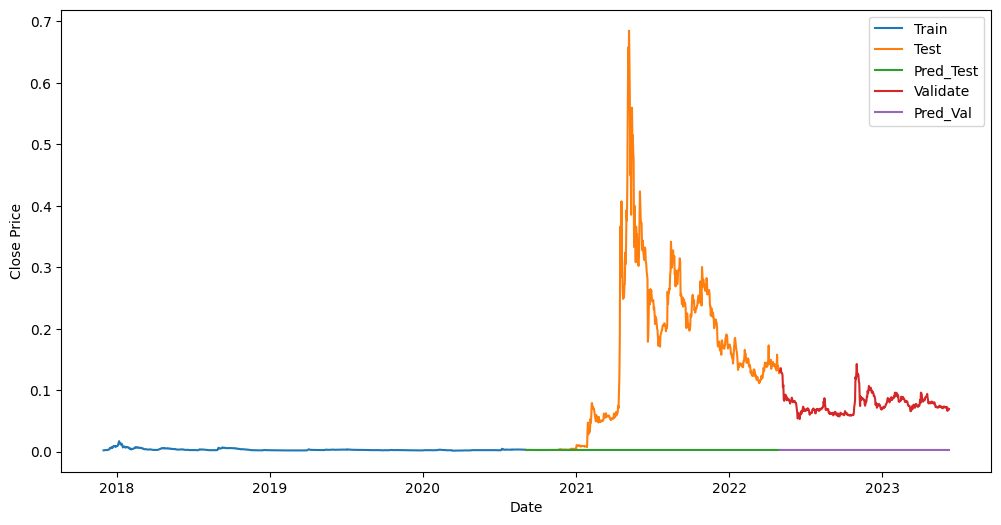

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(train_data1['Date'], train_data1['Close'], label='Train')
plt.plot(test_data1['Date'], test_data1['Close'], label='Test')
plt.plot(test_data1['Date'], y_pred1, label='Pred_Test')
plt.plot(val_data1['Date'], val_data1['Close'], label='Validate')
plt.plot(val_data1['Date'], y_pred_val1, label='Pred_Val')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

In [ ]:
# Tính MAE
valid_mae1 = mean_absolute_error(y_val1, y_pred_val1)
test_mae1 = mean_absolute_error(y_test1, y_pred1)

# Tính toán RMSE
valid_rmse1 = np.sqrt(np.mean((y_pred_val1 - y_val1)**2))
test_rmse1 = np.sqrt(np.mean((y_pred1 - y_test1)**2))

# Tính MAPE
def mean_absolute_percentage_error(y_true, y_pred1):
    return np.mean(np.abs((y_true - y_pred1) / y_true)) * 100

valid_mape1 = mean_absolute_percentage_error(y_val1, y_pred_val1)
test_mape1 = mean_absolute_percentage_error(y_test1, y_pred1)

# Làm tròn đến số thứ 3 sau dấu phẩy
valid_mae1 = round(valid_mae1, 3)
test_mae1 = round(test_mae1, 3)
valid_rmse1 = round(valid_rmse1, 3)
test_rmse1 = round(test_rmse1, 3)
valid_mape1 = round(valid_mape1, 3)
test_mape1 = round(test_mape1, 3)

print('Validation MAE:', valid_mae1)
print('Validation RMSE:', valid_rmse1)
print('Validation MAPE:', valid_mape1)
print('Testing MAE:', test_mae1)
print('Testing RMSE:', test_rmse1)
print('Testing MAPE:', test_mape1)

Validation MAE: 0.017
Validation RMSE: 0.02
Validation MAPE: 25.642
Testing MAE: 0.023
Testing RMSE: 0.032
Testing MAPE: 33.778


In [ ]:
test_data.index

RangeIndex(start=1411, stop=1814, step=1)

## Tỉ lệ 6:2:2

In [ ]:
# Chia train, test, validate theo tỉ lệ 6:2:2
train_size = int(0.6 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [ ]:
# Tiến hành huấn luyện mô hình ARIMAX
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])
exog_train = np.array(train_data['Volume']).reshape(-1, 1)  # Sử dụng cột 'Volume' làm biến exogenous


In [ ]:
# Tìm mô hình ARIMAX tốt nhất bằng cách sử dụng auto_arima
model = auto_arima(y_train, exogenous=exog_train, trace=True, error_action='ignore', suppress_warnings=True)
# Fit mô hình
model.fit(y_train, exogenous=exog_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-12192.619, Time=2.79 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-12141.786, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-12143.452, Time=0.33 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-12142.508, Time=1.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-12142.986, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-12187.800, Time=1.53 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-11788.880, Time=1.55 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-12239.650, Time=4.91 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-12241.530, Time=2.19 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-12243.491, Time=1.82 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-12186.728, Time=0.73 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-12242.175, Time=2.48 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-12240.130, Time=2.89 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-12244.668, Time=0.64 sec
 ARIM

ARIMA(order=(3, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [ ]:
# Kiểm tra trên tập test
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
exog_test = np.array(test_data['Volume']).reshape(-1, 1)  # Sử dụng cột 'Volume' làm biến exogenous
y_pred = model.predict(n_periods=len(y_test), exogenous=exog_test)

# Kiểm tra trên tập validate
x_val = np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
exog_val = np.array(val_data['Volume']).reshape(-1, 1)  # Sử dụng cột 'Volume' làm biến exogenous
y_pred_val = model.predict(n_periods=len(y_val), exogenous=exog_val)

In [ ]:
# # Tạo index dự đoán cho 30 ngày tiếp theo
# last_index = df.index[-1]
# x_next_30_days = np.array(range(last_index + 1, last_index + 31)).reshape(-1, 1)
# y_next_30_days = model.predict(n_periods=len(x_next_30_days), exogenous=x_next_30_days)

# # In ra kết quả dự đoán 30 ngày
# print('Predicted closing prices for the next 30 days:')
# for i in range(len(y_next_30_days)):
#     print(f'Day {i+1}: {y_next_30_days[i]}')


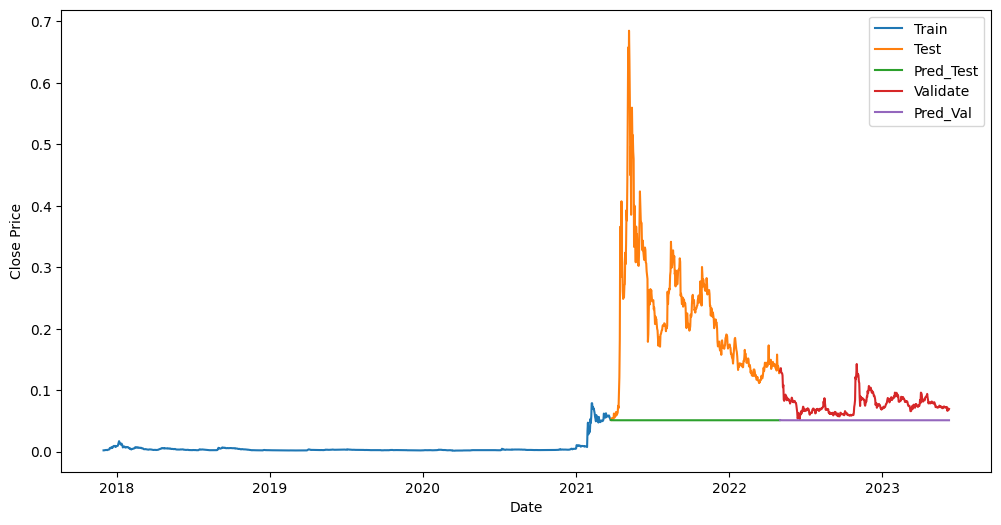

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train_data['Date'], train_data['Close'], label='Train')
plt.plot(test_data['Date'], test_data['Close'], label='Test')
plt.plot(test_data['Date'], y_pred, label='Pred_Test')
plt.plot(val_data['Date'], val_data['Close'], label='Validate')
plt.plot(val_data['Date'], y_pred_val, label='Pred_Val')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

In [ ]:
# Dự đoán giá 7 ngày tiếp theo
num_days = 7
last_date = df['Date'].iloc[-1]  # Ngày cuối cùng trong tập dữ liệu
next_dates = pd.date_range(start=last_date + pd.DateOffset(1), periods=num_days, freq='D')  # Tạo danh sách các ngày tiếp theo
exog_next = np.array(val_data['Volume']).reshape(-1, 1)  # Sử dụng cột 'Volume' làm biến exogenous
next_prices = model.predict(n_periods=num_days, exogenous=exog_next)
predicted_prices = [f"Day {i+1}: {price}" for i, price in enumerate(next_prices)]

# In ra kết quả dự đoán 7 ngày tiếp theo
print('Predicted Prices for the Next 7 Days:')
for prediction in predicted_prices:
    print(prediction)
print('--------------------------------------')
# In ra kết quả dự đoán 7 ngày trước
print('Predicted Prices for the Previous 7 Days:')
previous_prices = y_pred[-7:]  # Lấy 7 dự đoán gần nhất
for i, price in enumerate(previous_prices):
    day = len(y_train) + len(y_test) + i + 1
    print(f"Day {day}: {price}")

Predicted Prices for the Next 7 Days:
Day 1: 0.0514933587123063
Day 2: 0.05151656792277896
Day 3: 0.05114589934793274
Day 4: 0.05110440515736431
Day 5: 0.0511758365968061
Day 6: 0.05110017725608697
Day 7: 0.05108018069610284
--------------------------------------
Predicted Prices for the Previous 7 Days:
Day 1614: 0.05109244333548548
Day 1615: 0.05109244333548548
Day 1616: 0.05109244333548548
Day 1617: 0.05109244333548548
Day 1618: 0.05109244333548548
Day 1619: 0.05109244333548548
Day 1620: 0.05109244333548548


In [ ]:
# Tính MAE
valid_mae = mean_absolute_error(y_val, y_pred_val)
test_mae = mean_absolute_error(y_test, y_pred)

# Tính toán RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))

# Tính MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

valid_mape = mean_absolute_percentage_error(y_val, y_pred_val)
test_mape = mean_absolute_percentage_error(y_test, y_pred)

# Làm tròn đến số thứ 3 sau dấu phẩy
valid_mae = round(valid_mae, 3)
test_mae = round(test_mae, 3)
valid_rmse = round(valid_rmse, 3)
test_rmse = round(test_rmse, 3)
valid_mape = round(valid_mape, 3)
test_mape = round(test_mape, 3)

print('Validation MAE:', valid_mae)
print('Validation RMSE:', valid_rmse)
print('Validation MAPE:', valid_mape)
print('Testing MAE:', test_mae)
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)

Validation MAE: 0.027
Validation RMSE: 0.03
Validation MAPE: 32.077
Testing MAE: 0.169
Testing RMSE: 0.196
Testing MAPE: 71.293


In [ ]:
test_data.index

RangeIndex(start=1210, stop=1613, step=1)

# XLM-USD

In [ ]:
# Đọc dữ liệu từ file CSV
df2 = pd.read_csv('/content/drive/MyDrive/HK6_2022-2023/IS403.N22.HTCL - Phân tích dữ liệu kinh doanh/IS403_Team15/Project/Dataset/XLM-USD.csv')

# Xử lý dữ liệu
df2 = df2[['Date', 'Close', 'Volume']]  # Chỉ lấy cột 'Date', 'Close' và 'Volume'
df2['Date'] = pd.to_datetime(df2['Date'])
df2 = df2.dropna().reset_index(drop=True)

## Tỉ lệ 7:2:1

In [ ]:
# Chia train, test, validate theo tỉ lệ 7:2:1
train_size = int(0.7 * len(df2))
test_size = int(0.2 * len(df2))
val_size = len(df2) - train_size - test_size

train_data = df2[:train_size]
test_data = df2[train_size:train_size+test_size]
val_data = df2[train_size+test_size:]

In [ ]:
# Tiến hành huấn luyện mô hình ARIMAX
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])
exog_train = np.array(train_data['Volume']).reshape(-1, 1)  # Sử dụng cột 'Volume' làm biến exogenous


In [ ]:
# Tìm mô hình ARIMAX tốt nhất bằng cách sử dụng auto_arima
model = auto_arima(y_train, exogenous=exog_train, trace=True, error_action='ignore', suppress_warnings=True)
# Fit mô hình
model.fit(y_train, exogenous=exog_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-6836.142, Time=2.85 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6830.913, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6833.580, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6833.271, Time=0.63 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-6832.813, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-6829.355, Time=1.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-6830.945, Time=1.22 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-6829.046, Time=1.74 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-6833.061, Time=2.23 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-6831.979, Time=0.63 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-6840.285, Time=3.87 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-6832.581, Time=0.87 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-6838.070, Time=3.53 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-6833.382, Time=0.66 sec
 ARIMA(0,1,4)(0,0,0

ARIMA(order=(1, 1, 3), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [ ]:
# Kiểm tra trên tập test
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
exog_test = np.array(test_data['Volume']).reshape(-1, 1)  # Sử dụng cột 'Volume' làm biến exogenous
y_pred = model.predict(n_periods=len(y_test), exogenous=exog_test)

# Kiểm tra trên tập validate
x_val = np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
exog_val = np.array(val_data['Volume']).reshape(-1, 1)  # Sử dụng cột 'Volume' làm biến exogenous
y_pred_val = model.predict(n_periods=len(y_val), exogenous=exog_val)

In [ ]:
# # Tạo index dự đoán cho 30 ngày tiếp theo
# last_index = df.index[-1]
# x_next_30_days = np.array(range(last_index + 1, last_index + 31)).reshape(-1, 1)
# y_next_30_days = model.predict(n_periods=len(x_next_30_days), exogenous=x_next_30_days)

# # In ra kết quả dự đoán 30 ngày
# print('Predicted closing prices for the next 30 days:')
# for i in range(len(y_next_30_days)):
#     print(f'Day {i+1}: {y_next_30_days[i]}')


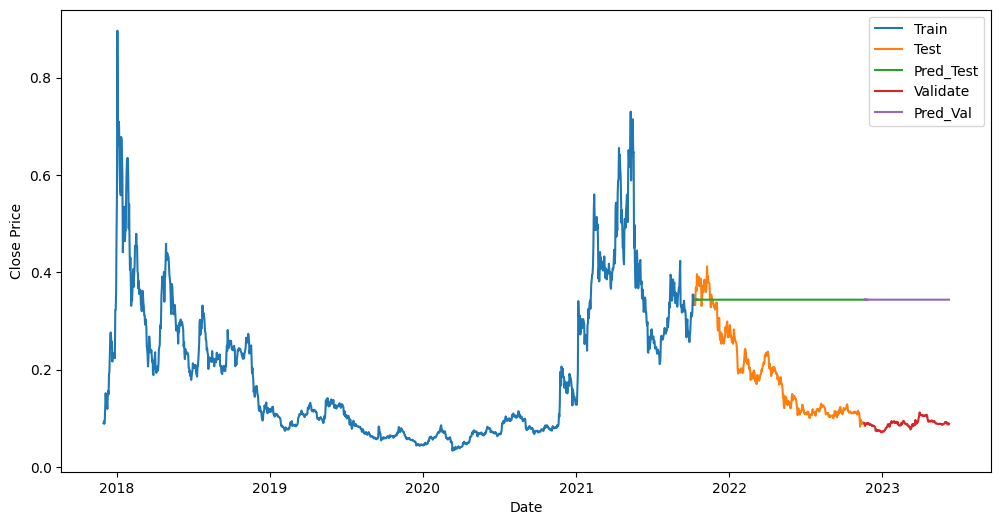

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train_data['Date'], train_data['Close'], label='Train')
plt.plot(test_data['Date'], test_data['Close'], label='Test')
plt.plot(test_data['Date'], y_pred, label='Pred_Test')
plt.plot(val_data['Date'], val_data['Close'], label='Validate')
plt.plot(val_data['Date'], y_pred_val, label='Pred_Val')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

In [ ]:
# Dự đoán giá 7 ngày tiếp theo
num_days = 7
last_date = df['Date'].iloc[-1]  # Ngày cuối cùng trong tập dữ liệu
next_dates = pd.date_range(start=last_date + pd.DateOffset(1), periods=num_days, freq='D')  # Tạo danh sách các ngày tiếp theo
exog_next = np.array(val_data['Volume']).reshape(-1, 1)  # Sử dụng cột 'Volume' làm biến exogenous
next_prices = model.predict(n_periods=num_days, exogenous=exog_next)
predicted_prices = [f"Day {i+1}: {price}" for i, price in enumerate(next_prices)]

# In ra kết quả dự đoán 7 ngày tiếp theo
print('Predicted Prices for the Next 7 Days:')
for prediction in predicted_prices:
    print(prediction)
print('--------------------------------------')
# In ra kết quả dự đoán 7 ngày trước
print('Predicted Prices for the Previous 7 Days:')
previous_prices = y_pred[-7:]  # Lấy 7 dự đoán gần nhất
for i, price in enumerate(previous_prices):
    day = len(y_train) + len(y_test) + i + 1
    print(f"Day {day}: {price}")

Predicted Prices for the Next 7 Days:
Day 1: 0.34370167437628063
Day 2: 0.34298945165537265
Day 3: 0.344330652662895
Day 4: 0.3431915073926744
Day 5: 0.3441590371957299
Day 6: 0.34333726850276997
Day 7: 0.34403523541045217
--------------------------------------
Predicted Prices for the Previous 7 Days:
Day 1815: 0.34371468109560066
Day 1816: 0.34371468109560066
Day 1817: 0.34371468109560066
Day 1818: 0.34371468109560066
Day 1819: 0.34371468109560066
Day 1820: 0.34371468109560066
Day 1821: 0.34371468109560066


In [ ]:
# Tính MAE
valid_mae = mean_absolute_error(y_val, y_pred_val)
test_mae = mean_absolute_error(y_test, y_pred)

# Tính toán RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))

# Tính MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

valid_mape = mean_absolute_percentage_error(y_val, y_pred_val)
test_mape = mean_absolute_percentage_error(y_test, y_pred)

# Làm tròn đến số thứ 3 sau dấu phẩy
valid_mae = round(valid_mae, 3)
test_mae = round(test_mae, 3)
valid_rmse = round(valid_rmse, 3)
test_rmse = round(test_rmse, 3)
valid_mape = round(valid_mape, 3)
test_mape = round(test_mape, 3)

print('Validation MAE:', valid_mae)
print('Validation RMSE:', valid_rmse)
print('Validation MAPE:', valid_mape)
print('Testing MAE:', test_mae)
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)

Validation MAE: 0.255
Validation RMSE: 0.255
Validation MAPE: 290.214
Testing MAE: 0.16
Testing RMSE: 0.178
Testing MAPE: 120.219


In [ ]:
test_data.index

RangeIndex(start=1411, stop=1814, step=1)

## Tỉ lệ 5:3:2

In [ ]:
# Chia train, test, validate theo tỉ lệ 5:3:2
train_size1 = int(0.5 * len(df))
test_size1 = int(0.3 * len(df))
val_size1 = len(df) - train_size1 - test_size1

train_data1 = df[:train_size1]
test_data1 = df[train_size1:train_size1+test_size1]
val_data1 = df[train_size1+test_size1:]

In [ ]:
# Tiến hành huấn luyện mô hình ARIMAX
x_train1 = np.array(train_data1.index).reshape(-1, 1)
y_train1 = np.array(train_data1['Close'])
exog_train1 = np.array(train_data1['Volume']).reshape(-1, 1)  # Sử dụng cột 'Volume' làm biến exogenous

# Tìm mô hình ARIMAX tốt nhất bằng cách sử dụng auto_arima
model = auto_arima(y_train1, exogenous=exog_train1, trace=True, error_action='ignore', suppress_warnings=True)

# Fit mô hình
model.fit(y_train1, exogenous=exog_train1)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-7804.328, Time=2.39 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-7749.881, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-7753.469, Time=0.52 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-7753.165, Time=0.50 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-7751.823, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-7808.144, Time=4.50 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-7747.564, Time=0.95 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-7745.880, Time=0.26 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-7872.431, Time=1.62 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-7850.662, Time=2.00 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-7880.762, Time=2.66 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-7880.316, Time=3.79 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=-7886.439, Time=4.05 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-7888.373, Time=2.98 sec
 ARIMA(0,1,4)(0,0,0

ARIMA(order=(1, 1, 5), scoring_args={}, suppress_warnings=True)

In [ ]:
# Kiểm tra trên tập test
x_test1 = np.array(test_data1.index).reshape(-1, 1)
y_test1 = np.array(test_data1['Close'])
exog_test1 = np.array(test_data1['Volume']).reshape(-1, 1)  # Sử dụng cột 'Volume' làm biến exogenous
y_pred1 = model.predict(n_periods=len(y_test1), exogenous=exog_test1)

# Kiểm tra trên tập validate
x_val1 = np.array(val_data1.index).reshape(-1, 1)
y_val1 = np.array(val_data1['Close'])
exog_val1 = np.array(val_data1['Volume']).reshape(-1, 1)  # Sử dụng cột 'Volume' làm biến exogenous
y_pred_val1 = model.predict(n_periods=len(y_val1), exogenous=exog_val1)


In [ ]:
# # Tạo index dự đoán cho 30 ngày tiếp theo
# last_index1 = df.index[-1]
# x_next1_30_days = np.array(range(last_index1 + 1, last_index1 + 31)).reshape(-1, 1)
# y_next1_30_days = model.predict(n_periods=len(x_next1_30_days), exogenous=x_next1_30_days)

# # In ra kết quả dự đoán 30 ngày
# print('Predicted closing prices for the next 30 days:')
# for i in range(len(y_next1_30_days)):
#     print(f'Day {i+1}: {y_next1_30_days[i]}')

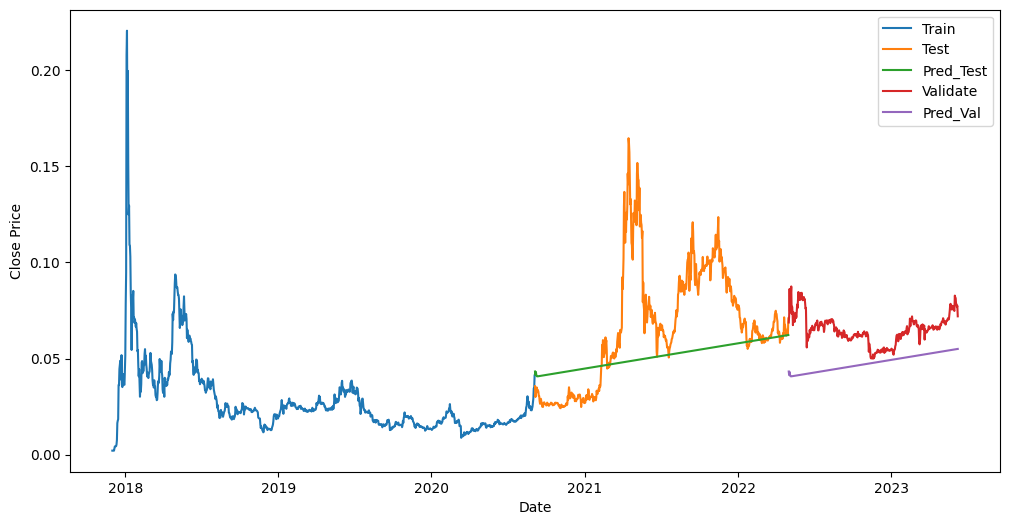

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train_data1['Date'], train_data1['Close'], label='Train')
plt.plot(test_data1['Date'], test_data1['Close'], label='Test')
plt.plot(test_data1['Date'], y_pred1, label='Pred_Test')
plt.plot(val_data1['Date'], val_data1['Close'], label='Validate')
plt.plot(val_data1['Date'], y_pred_val1, label='Pred_Val')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

In [ ]:
# Dự đoán giá 7 ngày tiếp theo
num_days = 7
last_date = df['Date'].iloc[-1]  # Ngày cuối cùng trong tập dữ liệu
next_dates = pd.date_range(start=last_date + pd.DateOffset(1), periods=num_days, freq='D')  # Tạo danh sách các ngày tiếp theo
exog_next = np.array(val_data['Volume']).reshape(-1, 1)  # Sử dụng cột 'Volume' làm biến exogenous
next_prices = model.predict(n_periods=num_days, exogenous=exog_next)
predicted_prices = [f"Day {i+1}: {price}" for i, price in enumerate(next_prices)]

# In ra kết quả dự đoán 7 ngày tiếp theo
print('Predicted Prices for the Next 7 Days:')
for prediction in predicted_prices:
    print(prediction)
print('--------------------------------------')
# In ra kết quả dự đoán 7 ngày trước
print('Predicted Prices for the Previous 7 Days:')
previous_prices = y_pred[-7:]  # Lấy 7 dự đoán gần nhất
for i, price in enumerate(previous_prices):
    day = len(y_train) + len(y_test) + i + 1
    print(f"Day {day}: {price}")

Predicted Prices for the Next 7 Days:
Day 1: 0.043276608002014966
Day 2: 0.041391141211731236
Day 3: 0.043072320824296524
Day 4: 0.04157865199298553
Day 5: 0.04089121657927685
Day 6: 0.04076674552659892
Day 7: 0.04076711686630154
--------------------------------------
Predicted Prices for the Previous 7 Days:
Day 1815: 0.34371468109560066
Day 1816: 0.34371468109560066
Day 1817: 0.34371468109560066
Day 1818: 0.34371468109560066
Day 1819: 0.34371468109560066
Day 1820: 0.34371468109560066
Day 1821: 0.34371468109560066


In [ ]:
# Tính MAE
valid_mae1 = mean_absolute_error(y_val1, y_pred_val1)
test_mae1 = mean_absolute_error(y_test1, y_pred1)

# Tính toán RMSE
valid_rmse1 = np.sqrt(np.mean((y_pred_val1 - y_val1)**2))
test_rmse1 = np.sqrt(np.mean((y_pred1 - y_test1)**2))

# Tính MAPE
def mean_absolute_percentage_error(y_true, y_pred1):
    return np.mean(np.abs((y_true - y_pred1) / y_true)) * 100

valid_mape1 = mean_absolute_percentage_error(y_val1, y_pred_val1)
test_mape1 = mean_absolute_percentage_error(y_test1, y_pred1)

# Làm tròn đến số thứ 3 sau dấu phẩy
valid_mae1 = round(valid_mae1, 3)
test_mae1 = round(test_mae1, 3)
valid_rmse1 = round(valid_rmse1, 3)
test_rmse1 = round(test_rmse1, 3)
valid_mape1 = round(valid_mape1, 3)
test_mape1 = round(test_mape1, 3)

print('Validation MAE:', valid_mae1)
print('Validation RMSE:', valid_rmse1)
print('Validation MAPE:', valid_mape1)
print('Testing MAE:', test_mae1)
print('Testing RMSE:', test_rmse1)
print('Testing MAPE:', test_mape1)

Validation MAE: 0.017
Validation RMSE: 0.02
Validation MAPE: 25.642
Testing MAE: 0.023
Testing RMSE: 0.032
Testing MAPE: 33.778


In [ ]:
test_data.index

RangeIndex(start=1411, stop=1814, step=1)

## Tỉ lệ 6:2:2

In [ ]:
# Chia train, test, validate theo tỉ lệ 6:2:2
train_size = int(0.6 * len(df2))
test_size = int(0.2 * len(df2))
val_size = len(df2) - train_size - test_size

train_data = df2[:train_size]
test_data = df2[train_size:train_size+test_size]
val_data = df2[train_size+test_size:]

In [ ]:
# Tiến hành huấn luyện mô hình ARIMAX
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])
exog_train = np.array(train_data['Volume']).reshape(-1, 1)  # Sử dụng cột 'Volume' làm biến exogenous


In [ ]:
# Tìm mô hình ARIMAX tốt nhất bằng cách sử dụng auto_arima
model = auto_arima(y_train, exogenous=exog_train, trace=True, error_action='ignore', suppress_warnings=True)
# Fit mô hình
model.fit(y_train, exogenous=exog_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-6109.432, Time=2.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6106.605, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6105.255, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6105.202, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-6108.433, Time=0.20 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-6109.952, Time=2.04 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-6105.167, Time=0.61 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-6102.840, Time=1.10 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-6117.807, Time=1.76 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-6106.871, Time=2.45 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-6123.518, Time=3.49 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-6124.263, Time=3.34 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-6114.801, Time=0.84 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=-6108.010, Time=2.87 sec
 ARIMA(3,1,4)(0,0,0

ARIMA(order=(3, 1, 3), scoring_args={}, suppress_warnings=True)

In [ ]:
# Kiểm tra trên tập test
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
exog_test = np.array(test_data['Volume']).reshape(-1, 1)  # Sử dụng cột 'Volume' làm biến exogenous
y_pred = model.predict(n_periods=len(y_test), exogenous=exog_test)

# Kiểm tra trên tập validate
x_val = np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
exog_val = np.array(val_data['Volume']).reshape(-1, 1)  # Sử dụng cột 'Volume' làm biến exogenous
y_pred_val = model.predict(n_periods=len(y_val), exogenous=exog_val)

In [ ]:
# # Tạo index dự đoán cho 30 ngày tiếp theo
# last_index = df.index[-1]
# x_next_30_days = np.array(range(last_index + 1, last_index + 31)).reshape(-1, 1)
# y_next_30_days = model.predict(n_periods=len(x_next_30_days), exogenous=x_next_30_days)

# # In ra kết quả dự đoán 30 ngày
# print('Predicted closing prices for the next 30 days:')
# for i in range(len(y_next_30_days)):
#     print(f'Day {i+1}: {y_next_30_days[i]}')


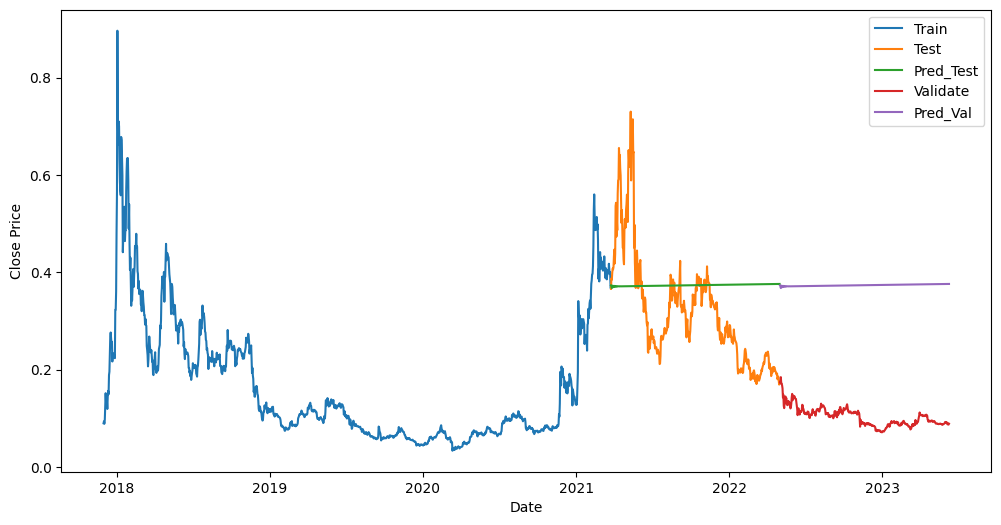

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train_data['Date'], train_data['Close'], label='Train')
plt.plot(test_data['Date'], test_data['Close'], label='Test')
plt.plot(test_data['Date'], y_pred, label='Pred_Test')
plt.plot(val_data['Date'], val_data['Close'], label='Validate')
plt.plot(val_data['Date'], y_pred_val, label='Pred_Val')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

In [ ]:
# Dự đoán giá 7 ngày tiếp theo
num_days = 7
last_date = df['Date'].iloc[-1]  # Ngày cuối cùng trong tập dữ liệu
next_dates = pd.date_range(start=last_date + pd.DateOffset(1), periods=num_days, freq='D')  # Tạo danh sách các ngày tiếp theo
exog_next = np.array(val_data['Volume']).reshape(-1, 1)  # Sử dụng cột 'Volume' làm biến exogenous
next_prices = model.predict(n_periods=num_days, exogenous=exog_next)
predicted_prices = [f"Day {i+1}: {price}" for i, price in enumerate(next_prices)]

# In ra kết quả dự đoán 7 ngày tiếp theo
print('Predicted Prices for the Next 7 Days:')
for prediction in predicted_prices:
    print(prediction)
print('--------------------------------------')
# In ra kết quả dự đoán 7 ngày trước
print('Predicted Prices for the Previous 7 Days:')
previous_prices = y_pred[-7:]  # Lấy 7 dự đoán gần nhất
for i, price in enumerate(previous_prices):
    day = len(y_train) + len(y_test) + i + 1
    print(f"Day {day}: {price}")

Predicted Prices for the Next 7 Days:
Day 1: 0.37301825680501743
Day 2: 0.3723874109192906
Day 3: 0.36751762934701165
Day 4: 0.3725092623872172
Day 5: 0.37196047753317024
Day 6: 0.3693506989304003
Day 7: 0.37101253276357377
--------------------------------------
Predicted Prices for the Previous 7 Days:
Day 1614: 0.3759515826630456
Day 1615: 0.3759644329896645
Day 1616: 0.37597728331628333
Day 1617: 0.3759901336429022
Day 1618: 0.37600298396952103
Day 1619: 0.3760158342961399
Day 1620: 0.37602868462275874


In [ ]:
# Tính MAE
valid_mae = mean_absolute_error(y_val, y_pred_val)
test_mae = mean_absolute_error(y_test, y_pred)

# Tính toán RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))

# Tính MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

valid_mape = mean_absolute_percentage_error(y_val, y_pred_val)
test_mape = mean_absolute_percentage_error(y_test, y_pred)

# Làm tròn đến số thứ 3 sau dấu phẩy
valid_mae = round(valid_mae, 3)
test_mae = round(test_mae, 3)
valid_rmse = round(valid_rmse, 3)
test_rmse = round(test_rmse, 3)
valid_mape = round(valid_mape, 3)
test_mape = round(test_mape, 3)

print('Validation MAE:', valid_mae)
print('Validation RMSE:', valid_rmse)
print('Validation MAPE:', valid_mape)
print('Testing MAE:', test_mae)
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)

Validation MAE: 0.27
Validation RMSE: 0.271
Validation MAPE: 273.43
Testing MAE: 0.106
Testing RMSE: 0.128
Testing MAPE: 40.133


In [ ]:
test_data.index

RangeIndex(start=1210, stop=1613, step=1)